In [6]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [7]:
import numpy as np
import matplotlib.pyplot as plt

The slope is 0.558 +/- 0.001
The intercept is 0.029 +/- 0.000


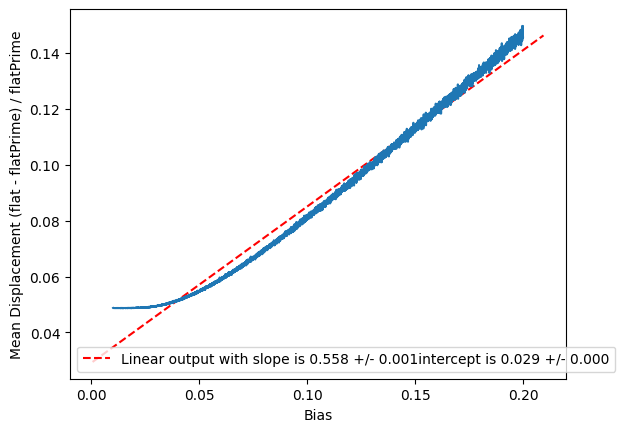

In [8]:
num_Of_pixels = 100
dark_prime_per_sec_pix = 2 
flatupper = 1.3
flatlower = 0.8
bias_electrons_per_atod = 400 
atod_gain = 10
biasErrupper = 0.2
biasErrlower = 0.01
time = 300 

# Define the range for random floats and the size of the array
min_value = flatlower
max_value = flatupper
bin = num_Of_pixels * num_Of_pixels 

# Generate an array of randomt floast for flat field 
flatPrime = np.random.uniform(min_value, max_value, bin)

# the bias per pixels 
bias = bias_electrons_per_atod * atod_gain 
# the error on the bias 
biasPrime = np.linspace(biasErrlower, biasErrupper, bin)
# the dark that should be
darkPrime = dark_prime_per_sec_pix * time
# flat field propagation 
mean_displacement = []
for b in biasPrime:  
    master_bias = np.random.normal(bias, bias * b, bin)
    master_dark = darkPrime + master_bias
    # unclear of whether to time or to subtract 
    flat = flatPrime * (master_dark + master_bias) 
    flat /= np.mean(flat)
    displacement = np.mean(np.abs((flat - flatPrime)) / flatPrime)
    mean_displacement.append(displacement) 
    
# plt.plot(biasPrime, mean_displacement)
# plt.title("BiasPropagation")
# # naming the x axis
# plt.xlabel('bias')
# # naming the y axis
# plt.ylabel('Displacement')
# plt.show()

fit = np.polyfit(biasPrime,mean_displacement,1,full=False, cov=True)


# Fit parameters are the first element in the returned "tuple"
fitparams = fit[0]
slope = fitparams[0]
intercept = fitparams[1]

# Covariance matrix is the second element in the returned "tuple"
cov = fit[1]

# This is the way you get errors out of the covariance matrix.
param_error = np.sqrt(np.diagonal(cov))
slope_error = param_error[0]
intercept_error = param_error[1]

slope_output = 'slope is %.3f +/- %0.3f' %(slope,slope_error)
intercept_output = 'intercept is %.3f +/- %0.3f' %(intercept,intercept_error)

plt.errorbar(biasPrime,mean_displacement)
plt.xlabel('Bias')
plt.ylabel('Mean Displacement (flat - flatPrime) / flatPrime')
xfit = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
yfit = intercept + slope*xfit
plt.plot(xfit,yfit,'r--', label='Linear output with ' + slope_output + intercept_output)
plt.legend()

print('The slope is %.3f +/- %0.3f' %(slope,slope_error))
print('The intercept is %.3f +/- %0.3f' %(intercept,intercept_error))
# plt.savefig('Slope Hist')

Text(0.5, 1.0, 'Normal Distribution')

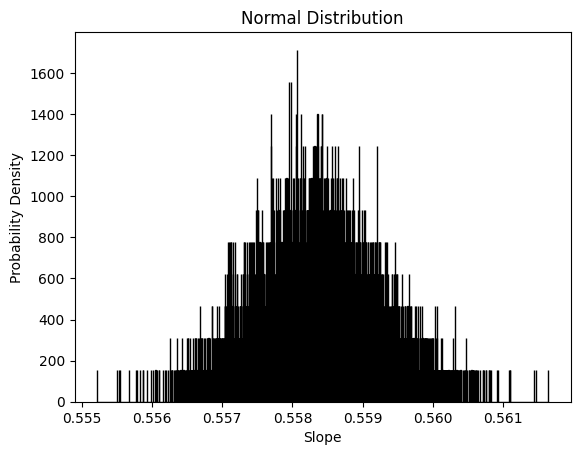

In [9]:
slope_normal = np.random.normal(slope, slope_error, bin)
plt.hist(slope_normal, bin, density = True, color='b', edgecolor='black')
plt.xlabel('Slope')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
# plt.savefig('Slope Hist')


Text(0.5, 1.0, 'Normal Distribution')

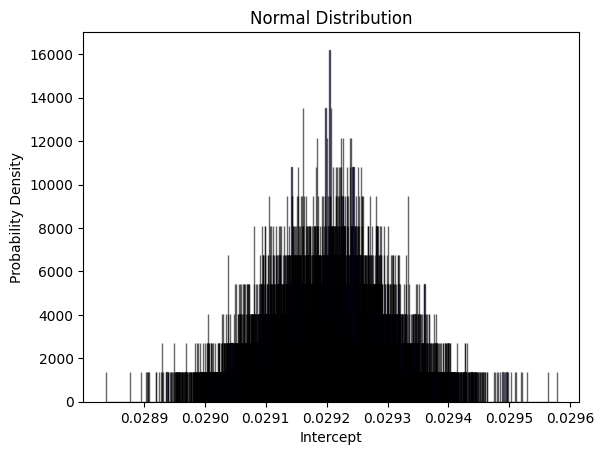

In [10]:
intercept_normal = np.random.normal(intercept, intercept_error, bin)
plt.hist(intercept_normal, bin, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlabel('Intercept')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
# plt.savefig('Intercept Hist')